In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.5.1


In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
sub = pd.DataFrame(test_data['time'])

In [3]:
train_data = train_data[train_data['temperature'].notnull()]
train_data = train_data.fillna(method='bfill')
test_data = test_data.fillna(method='bfill')

In [4]:
train_data.columns = ['time', 'year', 'month', 'day', 'hour', 'min', 'sec', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo',
                    'indoorHum', 'indoorAtmo', 'temperature']
test_data.columns = ['time', 'year', 'month', 'day', 'hour', 'min', 'sec', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo',
                   'indoorHum', 'indoorAtmo']

In [5]:
train_data = train_data.loc[(train_data['outdoorTemp'] >= test_data['outdoorTemp'].min()) & (train_data['outdoorTemp'] <= test_data['outdoorTemp'].max())]

In [6]:
all_features = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [7]:
all_features['indoorAtmo-outdoorAtmo'] = all_features['indoorAtmo'] - all_features['outdoorAtmo']
all_features['indoorHum-outdoorHum'] = all_features['indoorHum'] - all_features['outdoorHum']

In [8]:
print(all_features.columns.to_list())

['time', 'year', 'month', 'day', 'hour', 'min', 'sec', 'outdoorTemp', 'outdoorHum', 'outdoorAtmo', 'indoorHum', 'indoorAtmo', 'temperature', 'indoorAtmo-outdoorAtmo', 'indoorHum-outdoorHum']


In [9]:
drop_features = ['time', 'year', 'month', 'day', 'hour', 'min', 'sec']
all_features.drop(drop_features, axis=1, inplace=True)

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float)
train_labels = torch.tensor(train_data.temperature.values,
                            dtype=torch.float).view(-1, 1)

In [11]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    # 初始化模型参数
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [12]:
def log_rmse(net, features, labels):
    # 不追踪其上操作
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    
    # TensorDataset 将特征和标签拼接起来
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    
    # 随机小批量读取数据
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(),
                                 lr=learning_rate,  # 学习率
                                 weight_decay=weight_decay)  # 权重衰减
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 计算loss
            l = loss(net(X.float()), y.float())
            # 梯度清零
            optimizer.zero_grad()
            # 计算梯度
            l.backward()
            # 更新参数
            optimizer.step()
        train_ls.append(loss(net(train_features), train_labels))
        if test_labels is not None:
            test_ls.append(loss(net(test_features), test_labels))
    return train_ls, test_ls

In [14]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice 切片
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # torch.cat沿着轴向拼接
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [15]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'mse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train mse %f, valid mse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train mse 5.096513, valid mse 6.294266
fold 1, train mse 430.727509, valid mse 397.649017
fold 2, train mse 961.668823, valid mse 943.194519
fold 3, train mse 74892.468750, valid mse 65291.542969
fold 4, train mse 31539.373047, valid mse 30632.386719
5-fold validation: avg train rmse 21565.867188, avg valid rmse 19454.212891


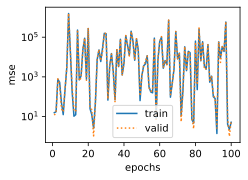

In [16]:
k = 5
num_epochs = 100
lr = 5
weight_decay = 0
batch_size = 64

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [17]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'mse')
    print('train mse %f' % train_ls[-1])
    # 如果不想要被继续追踪，可以调用.detach()将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪，这样梯度就传不过去了。
    # 此外，还可以用with torch.no_grad()将不想被追踪的操作代码块包裹起来，这种方法在评估模型的时候很常用，因为在评估模型时，我们并不需要计算可训练参数（requires_grad=True）的梯度。
    preds = net(test_features).detach().numpy()
    sub['temperature'] = pd.Series(preds.reshape(1, -1)[0])
    # submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    sub.to_csv('../sub/sub_pytorch.csv', index=False)

train mse 7135.275391


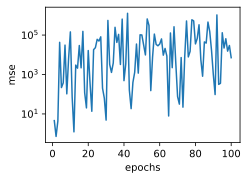

In [18]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)